# Alessandria, Kaboski, and Midrigan (2010)

This code solves the model in Alessandria, Kaboski, and Midrigan (2010, AER). 

All mistakes are my own. If you find any, please drop me a line. ruhl2@wisc.edu

Kim Ruhl, January 17, 2023

### The model in the paper
The firm's state is $s$ the inventory stock and $e$ the idiosyncratic demand shock. (the demand shock in the paper is $\nu$, there is still some cleaning up to do...) The value of placing an order (adjusting) is

$$V^a(s,e) = \max_{p, i} pq(p) -\omega i - f + \beta \text{E}_{e^\prime}V(s^\prime, e^\prime)\\
\text{s.t. } q(p)=\exp(e)(\frac{p}{P_m})^{-\sigma}C_m \leq s\\
s^\prime = (1-\delta)[s-q+i]
$$

The value of not ordering (not adjusting) is

$$V^n(s,e) = \max_{p} pq(p) + \beta \text{E}_{e^\prime}V(s^\prime, e^\prime)\\
\text{s.t. } q(p)=\exp(e)(\frac{p}{P_m})^{-\sigma}C_m \leq s\\
s^\prime = (1-\delta)[s-q]
$$

The value of the firm with state $(s,e)$ is
$$V(s, e) = \max \{V^a(s, e), V^n(s, e) \}$$

### The model we compute
We compute something slightly different. The constraints are all the same, but the value functions are

$$V^1(s,e) = \max_{p, i} pq(p) -\omega i - f + \beta V^3(s^\prime(s,e), e^\prime)$$
$$V^2(s,e) = \max_{p} pq(p) + \beta V^3(s^\prime(s,e), e^\prime)$$
$$V^3(s^\prime(s,e), e^\prime) = \text{E}_{e^\prime} \max \{V^1(s^\prime, e^\prime), V^2(s^\prime, e^\prime) \}$$

$V^1$ is defined in `valfunc1`, $V^2$ in `valfunc2` and $V^3$ in `valfunc3`.

## Functions

Notebooks are a clunky way to code stuff with functions, but I want the markdown cells to keep notes. So things are a bit nonlinear...

Go down to the last cell to find `main()` which executes the code. 

### 1. Create the $\nu$ shock process
1. Create a discrete approximation to $N(0, \nu^2)$ of k points.  
2. Discard the nodes and weights above and below the 0.999 quantile. 
3. Normalize the weights to sum to 1.

In [1]:
function init_shocks(vbar, k)
    d = Normal(0, vbar);
    e, w = qnwnorm(k, 0, vbar^2);          # e are the nodes and w the weights
    w = w[abs.(e).<=quantile(d, 0.999)];   # quantile(x,y): compute quantile y of vector x
    e = e[abs.(e).<=quantile(d, 0.999)];
    w /= sum(w);
    return e, w;
end

init_shocks (generic function with 1 method)

### 2. Create the inventory ($s$) state space

#### Determining the colocation nodes
We want more points near zero because that is where the value function will be most nonlinear. 

We use the scale parameter to change the density of points near zero. The figure shows the transformation. The y-values do not mean anything. To enable the figure, set `showme=1`.

Create a dict, `fspace`, that holds the approximation information. There are two entries: one for the inventory dimension and one for the demand shock dimension.

#### Inventory
approximation type = `:spli (spline)` <br>
break points = `range(smin[1]^scale, smax[1]^scale, length=n[1]).^(1/scale)`<br>
?? = `0`<br>
order of spline = `3`

```julia
[:spli, range(smin[1]^scale, smax[1]^scale, length=n[1]).^(1/scale), 0, 3]
```

#### Demand shocks
approximation type = `:lin (linear)` <br>
break points = `range(smin[1]^scale, smax[1]^scale, length=n[1]).^(1/scale)`<br>
?? = `0`<br>


```julia
 [:lin, range(smin[2], smax[2], length=n[2]), 0]
```


In [2]:
function init_state_space(smin_val, smax_val, emin_val, emax_val, showme, params)
    smin=[smin_val, emin_val];    # smin is a 2 dimensional object, with min value of inventories and min demand shock
    smax=[smax_val, emax_val];    # smax is a 2 dimensional object, with max value of inventories and max demand shock
    sigma, n_nodes_s, n_nodes_e = params["sigma"], params["n_nodes_s"], params["n_nodes_e"];    
    scale = 1-1/sigma;    
    
    # Plot the colocation points to see how scale operates
    if showme == 1 plot_scale_diagram(smin, smax, scale, n_nodes[1]); end
    
    fspace = fundef([:spli, range(smin[1]^scale, smax[1]^scale, length=n_nodes_s).^(1/scale), 0, 3], 
                    [:lin,  range(smin[2], smax[2],             length=n_nodes_e), 0]);
    
    s   = funnode(fspace)[1];        # matrix of all possible combinations of inventory and demand
    Phi = funbase(fspace, s);      # basis functions evaluated at the colocation nodes
    
    return fspace, s, smin, smax, Phi;
    
end

init_state_space (generic function with 1 method)

In [3]:
function plot_scale_diagram(smin, smax, scale, Ns)
     plt  = plot(range(smin[1], smax[1], length=Ns), range(0, 0, length=Ns), seriestype=:scatter, 
        label="Original, uniform spaced", title="The effect of scale on the placement of nodes")
        
    plot!(range(smin[1]^scale, smax[1]^scale, length=Ns), range(0.1, 0.1, length=31), 
            seriestype=:scatter, label="Scale endpoints, uniform spaced")
        
    plot!(range(smin[1]^scale, smax[1]^scale, length=Ns).^(1/scale), range(0.2, 0.2, length=Ns), 
            seriestype=:scatter, label="Scaled")
        
    plot!(legend=:right, foreground_color_legend = nothing)
    display(plt)
end

plot_scale_diagram (generic function with 1 method)

## 3. Solve the value functions

There are three value functions: 
1. adjust (`v1`)
2. do not adjust (`v2`) 
3. expected value of max of 1 and 2 (`v3`)

The first loop uses value function iteration to create a decent guess for the policy function iteration in the second loop. The policy function iteration uses Newton's method, so a good guess helps a lot. 

In [4]:
function solve_v(s, e, w, fspace, params)
    sigma, omega, beta, ns = params["sigma"], params["omega"], params["beta"], params["ns"];
     vfi_its, pfi_max_its, vfi_tol, pfi_tol =  params["vfi_its"], params["pfi_max_its"], params["vfi_tol"], params["pfi_tol"];
        
    # Compute the basis coefficients that approximate the three value functions `[va, va, va]` at the points `s`.
    # Then compute the intial guess of the value function in this interpolation scheme.
    reward = 1/sigma;
    va = omega*s[:,1] .+ exp.(s[:,2])./sigma .+ beta*reward/(1-beta);
    cnew = funfitxy(fspace, s, [va va va])[1];
    vnew = funeval(cnew, fspace, s)[1][:,:];
    
    # VFI for a few iterations to get a good guess for Newton's method
    for it = 1:vfi_its
        cold = copy(cnew);
        vold = copy(vnew);
        
        v1, v2      = saveBelmax(:not, cold, fspace, s, e, w, params);
        cnew[:,1:2] = funfitxy(fspace,s,[v1 v2])[1];
        v3          = valfunc3(cnew, fspace, s, [],e, w, params);
        cnew[:,3]   = funfitxy(fspace,s,v3)[1]; 
        
        vnew        = funeval(cnew, fspace, s)[1][:,:];

        println([it, round(norm(vold-vnew),digits=2)]);
        if (norm(vold-vnew)<vfi_tol) | (it==vfi_its) 
            #CSV.write("vnew.csv", Tables.table(vnew), writeheader=false);
            break;
        end
   end
    
    
    # PFI using Newton's method
    cnew = cnew[:];    # transform array cnew to a vector (column-major ordering)
    for it = 1:pfi_max_its
        cold = copy(cnew);
        vold = copy(vnew);
        
        bel, beljac = solvebel(cold, fspace, s, e, w, params);
        cnew = cold - (beljac\bel);
        
        vnew = funeval([cnew[1:ns,:] cnew[ns+1:2*ns,:] cnew[2*ns+1:3*ns,:]],fspace,s)[1];
        
        println([it round(norm(vold-vnew),sigdigits=2)]);
        
        if norm(vold-vnew)<pfi_tol 
            CSV.write("vnew-kr.csv", Tables.table(vnew[:,:]), writeheader=false)
            break;  
        end
        
    end

    return vnew, [cnew[1:ns,:] cnew[ns+1:2*ns,:] cnew[2*ns+1:3*ns,:]]
end

solve_v (generic function with 1 method)

### saveBelmax

This code has two modes: 

1. If not `:full`, then, given a coefficient vector c, update the V1 and V2. Return the updated V1 and V2. 
2. If `:full`, then, given a coefficient vector c, update V1 and V2 and compute V3. Also compute the value-function derivatives V13, V23, V31, V32.

In [5]:
function saveBelmax(case::Symbol,c,fspace,s,e,w,params)
# In the :not case, given c, update the policy function with solve 1 and solve 2
# then compute the new value functions v1 and v2 given the update policy function.

# In the :full case do everything in the :not case but also compute the derivatives of v wrt c.

    beta, ns = params["beta"], params["ns"];

    # Given c, find optimal policy when ordering (xadjust)
    x = solve1(c, fspace, s, [], e, w, params);
    xadjust = [x[1] x[2]];
    v1 = valfunc1(c, fspace, s, xadjust, e, w, params);

    # Given c, find optimal policy when not ordering (xnadjust)
    x = solve2(c, fspace, s, x, e, w, params);
    xnadjust = x;
    v2 = valfunc2(c, fspace, s, xnadjust, e, w, params);

    if case!=:full  
        return v1, v2, xadjust, xnadjust;
    end


    if case==:full

        # Given c, compute V3
        v3 = valfunc3(c, fspace, s, [], e, w, params);

        v13, v23, v31, v32 =zeros(Float64,ns,ns), zeros(Float64,ns,ns), zeros(Float64,ns,ns), zeros(Float64,ns,ns);
        
        # Derivative of V1 wrt the coefficents in V3
        g = law_of_motion_adj(s, xadjust, params);
        v13 = beta.*funbase(fspace,g);

        # Derivative of V2 wrt the coefficents in V3
        g = law_of_motion_nadj(s, xnadjust, params);
        v23 = beta.*funbase(fspace,g);

        # Derivatives of V3 wrt to the coefficents in V1 and V2
        # Only take the coefficents from the V1 or V2 for the chosen action.
        for k in eachindex(w)  

            g = [s[:,1] e[k].*ones(ns,1)];

            vint1  = funeval(c[:,1], fspace, g)[1];        
            vint2  = funeval(c[:,2], fspace, g)[1];

            c1=vint1.>=vint2;
            c2=vint2.>vint1;

            v31 = v31 .+ w[k].*(funbase(fspace,g).*repeat(c1,1,ns));
            v32 = v32 .+ w[k].*(funbase(fspace,g).*repeat(c2,1,ns));

        end
        return v1,v2,v3,v13,v23,v31,v32
    end

end

saveBelmax (generic function with 1 method)

### solvebel

Each value function is of the form 
$$ V = \max_x f(x) + \beta P(x) V$$

The function ```solvebel()``` computes two things: 

1. $V - [f(x^*) + \beta P(x^*) V$], where $x^*$ is the optimal value of $x$. The $V$ from the left-hand side is the one computed from the previous iteration. The right-hand side uses is the maximized values computed in `saveBelmax()`. There are three value functions and they are stacked up and saved in `bel`, which is a $3ns\times1$ vector.

2. The Jacobian matrix of $V$ with respect to the coefficients $c$. This is an $3ns\times 3ns$ matrix. Think of this as a three by three matrix, where each element of the matrix is a $ns \times ns$ submatrix. 

Since $$\frac{\partial V^i(x)}{\partial c^i}=\phi^i(x) \qquad i=1,2,3 $$

the diagonal blocks of the Jacobian are the blocks of basis coefficients, $\Phi$. 

$$\begin{pmatrix}
\Phi &0 &-V_{13} \\
0  &\Phi &-V_{23} \\
-V_{31} &-V_{32} &\Phi
\end{pmatrix}$$


The (1,2) and (2,1) blocks are zeros since $V^1$ is not in $V^2$ and vice versa. They interact through $V^3$.

$V_{13}$ are the derivatives of $V^1$ w.r.t. the $c$ coefficients in $V^3$,

$$V^1(s,e) -  [p^*q(p) -\omega i^* - f + \beta V^3(s^\prime(s,e), e^\prime)].$$

By the envelope theorem the derivative of the current profits is zero, so

$$\frac{\partial V^1(s,e)}{\partial c^3} = -\beta\frac{\partial V^3(s^\prime(s,e), e^\prime)}{\partial c^3}= -\beta \phi^3(s^\prime(s,e), e^\prime)).$$

For the derivatives of $V^3$ we need to collect the coefficients from the value function $V^1$ or $V^2$ that corresponds to the chosen action.
$$\frac{\partial V^3(s,e)}{\partial c^1} = \text{E}_e \left[\frac{\partial V^1(s,e)}{\partial c^1}\textbf{I}_{V1\geq V2}+\frac{\partial V^2(s,e)}{\partial c^1}\textbf{I}_{V1<V2} \right]=\text{E}_e\left[\phi^1(s,e)\textbf{I}_{V1\geq V2}+\phi^2(s,e)\textbf{I}_{V1< V2}\right]$$

In [6]:
function solvebel(c, fspace, s, e, w, params)

    ns=params["ns"];
    c=[c[1:ns,:] c[ns+1:2*ns,:] c[2*ns+1:3*ns,:]];

    # saveBelmax returns the optimized Bellman equations (RHS) v1, v2, v3 and the derivatives
    v1,v2,v3,v13,v23,v31,v32 = saveBelmax(:full,c,fspace,s,e,w,params);

    # The stacked up Bellman equations: LHS-RHS
    bel = zeros(Float64, 3*ns, 1);
    LHS = funeval(c,fspace,s)[1];                                         # LHS of Bellman equation
    
    bel[1:ns,:]        = LHS[:,1] .- v1;                                  # LHS-RHS of Bellman equation for adjustment
    bel[ns+1:2*ns,:]   = LHS[:,2] .- v2;                                  # LHS-RHS of bellman equation for non-adjustment
    bel[2*ns+1:3*ns,:] = LHS[:,3] .- v3;                                  # LHS-RHS of bellman equation exp value of firm

    # The Jacobian matrix of bel wrt. c
    beljac = zeros(Float64, 3*ns, 3*ns);

    beljac[1:ns,:]        = [params["Phi"]   zeros(ns,ns)     -v13];   
    beljac[ns+1:2*ns,:]   = [zeros(ns,ns)    params["Phi"]    -v23];   
    beljac[2*ns+1:3*ns,:] = [-v31            -v32             params["Phi"]];

    return bel, beljac

end

solvebel (generic function with 1 method)

## Find the policy functions

There are two functions for finding the optimal policy. 

1. `solve1()` finds prices and order sizes to maximize V1, the value of adjusting.
2. `solve2()` finds prices to maximize V2, the value of not adjusting. 

In [7]:
function solve1(c, fspace, s, x, e, w, params)
# Compute order size and price, conditional on making an order
# TODO: In the inner loop over prices, we solve for all the optimal order size
# even though some of them are not not relevant to the "case". Maybe it speeds up
# if we only run best_order_size() of the subset of states which need solutions?

    tolp, toli = params["tolp"], params["toli"];
    alpha1 = (3-sqrt(5))/2;
    alpha2 = (sqrt(5)-1)/2;

    # Bounds for prices and inventories 
    ap, bp = get_price_bounds(params);
    ai, bi = get_inventory_bounds(s, params);

    # The initial trial points for prices and order sizes. We always use the same inital 
    # bounds when searching in order-size space, so these show up often below. 
    x1p0, x2p0, dp = init_guess(ap, bp, alpha1, alpha2);
    x1i0, x2i0, di = init_guess(ai, bi, alpha1, alpha2);

    # Find optimal order size given initial lower price bound (x1p0)
    xi = best_order_size(x1p0, di, x1i0, x2i0, toli, alpha2, c, fspace, s, e, w, params);
    f1p = valfunc1(c,fspace,s,[x1p0 xi],e,w,params);

    # Find optimal order size given initla upper price bound (x2p0)
    xi = best_order_size(x2p0, di, x1i0, x2i0, toli, alpha2, c, fspace, s, e, w, params);
    f2p = valfunc1(c,fspace,s,[x2p0 xi],e,w,params);


    # This is nested golden search. The outer loop is searching over price space.
    # For each given candidate price, search over order size (inner loop).
    f1pnew, f2pnew = f1p, f2p;
    x1pnew, x2pnew = x1p0, x2p0;

    # In need to declare these outside of the loop to make them available after the loop.
    xic1, xic2 = Array{Float64}(undef, params["ns"], 1), Array{Float64}(undef, params["ns"], 1);

    while sum(dp.>tolp)>0
        f1p, f2p = f1pnew, f2pnew;
        x1p, x2p =x1pnew, x2pnew;
        dp = dp*alpha2;

        # Find the next trial point. Note the two cases: 
        #   1. When f2p < f1p:  x2pnew = x1p and x1pnew = x1p-dp 
        #   2. When f2p >= f1p: x2pnew = x2p+dp and x1pnew = x2p 
        x2pnew =      x1p.*(f2p.<f1p) .+ (x2p+dp).*(f2p.>=f1p);
        x1pnew = (x1p-dp).*(f2p.<f1p) .+      x2p.*(f2p.>=f1p);
    
        # Case 1
        # For the states in which f2p < f1p, need to find optimal order size for x1pnew = x1p-dp
        xic1 = best_order_size(x1p.-dp, di, x1i0, x2i0, toli, alpha2, c, fspace, s, e, w, params);
        f1pnew=valfunc1(c,fspace,s,[x1p.-dp xic1],e,w, params).*(f2p.<f1p) .+ f2p.*(f2p.>=f1p);
    
        # Case 2
        # For the states in which f2p >= f1p, need to find optimal order size for x2pnew = x2p+dp
        xic2 = best_order_size(x2p.+dp, di, x1i0, x2i0, toli, alpha2, c, fspace, s, e, w, params);
        f2pnew=f1p.*(f2p.<f1p) .+ valfunc1(c,fspace,s,[x2p.+dp xic2],e,w,params).*(f2p.>=f1p);

    end
    # These are the optimal xp and xi
    xp = x1pnew.*(f1pnew.>f2pnew) .+ x2pnew.*(f1pnew.<=f2pnew);
    xi = xic1  .*(f1pnew.>f2pnew) .+ xic2  .*(f1pnew.<=f2pnew);

    return [xp, xi];
end

solve1 (generic function with 1 method)

### A few helper functions for `solve1()`

In [8]:
function init_guess(a, b, alpha1, alpha2)
    # Return initial trial points (x1, x2) and the inerval length (d).
    d  = b .- a;
    return a .+ alpha1*d, a .+ alpha2*d, alpha1*alpha2*d 
end


function best_order_size(xp, di, x1inew, x2inew, toli, alpha2, c, fspace, s, e, w, params)
# Given price xp, and the two x and two f values that bracket the max, 
# find the order size xi that maximizes the valfunc1. Uses golden section search.

    f1inew = valfunc1(c,fspace,s,[xp x1inew],e,w, params);
    f2inew = valfunc1(c,fspace,s,[xp x2inew],e,w, params);

    while sum(di.>toli)>0
        f1i, f2i =f1inew, f2inew;
        x1i, x2i =x1inew, x2inew;
        di = di*alpha2;

        x2inew = x1i.*(f2i.<f1i) .+ (x2i .+ di).*(f2i.>=f1i);
        f2inew = f1i.*(f2i.<f1i) .+ valfunc1(c,fspace,s,[xp x2i.+di],e,w,params).*(f2i.>=f1i);

        x1inew = (x1i .- di).*(f2i.<f1i) .+ x2i.*(f2i.>=f1i);
        f1inew = valfunc1(c,fspace,s,[xp x1i.-di],e,w, params).*(f2i.<f1i) .+ f2i.*(f2i.>=f1i);
    end

    xi = x2inew.*(f2inew.>=f1inew) .+ x1inew.*(f2inew.<f1inew);
    
    return xi; 
end

best_order_size (generic function with 1 method)

### Find the policy function when not placing an order

Search over prices. 

In [9]:
function solve2(c, fspace, s, x, e, w, params)
    # Use golden section search to find the optimal response if not placing an order. The only choice is price.
    # We are choosing price to maximize valfunc2().

    # Get bounds of price and set constants
    ap, bp = get_price_bounds(params);
    tolp = params["tolp"]
    alpha1 = (3-sqrt(5))/2;
    alpha2 = (sqrt(5)-1)/2;

    # Initial guess
    d  = bp .- ap;
    x1new = ap .+ alpha1*d;
    x2new = ap .+ alpha2*d;
    f1new = valfunc2(c, fspace, s, x1new, e, w, params);
    f2new = valfunc2(c, fspace, s, x2new, e, w, params);

    d = alpha1*alpha2*d;

    while sum(d.>tolp)>0
        f1, f2 = f1new, f2new;
        x1, x2, = x1new, x2new; 
        d = d*alpha2;
        
        x2new = x1.*(f2.<f1) .+ (x2.+d).*(f2.>=f1);
        f2new = f1.*(f2.<f1) .+ valfunc2(c, fspace, s, x2.+d, e, w, params).*(f2.>=f1);

        x1new = (x1.-d).*(f2.<f1) .+ x2.*(f2.>=f1);
        f1new = valfunc2(c, fspace, s, x1.-d, e, w, params).*(f2.<f1) .+ f2.*(f2.>=f1);
    end

    x = x2new.*(f2new.>=f1new) .+ x1new.*(f2new.<f1new);

    return x;

end

solve2 (generic function with 1 method)

### Compute the value functions

In [10]:
function valfunc1(c,fspace,s,x,e,w,params)
# For a given policy x, return V1, the value of adjusting.
    beta = params["beta"];
    g = law_of_motion_adj(s, x, params);
    
    return profit_adj(s, x, params) .+ beta.*funeval(c[:,3],fspace,g)[1];
end

valfunc1 (generic function with 1 method)

In [11]:
function valfunc2(c, fspace, s, x, e, w, params)
# For a given policy x, return the V2, the value of not adjusting.
    beta = params["beta"];
    g = law_of_motion_nadj(s, x, params)
    return profit_nadj(s, x, params) .+ beta.*funeval(c[:,3], fspace, g)[1];
end

valfunc2 (generic function with 1 method)

In [12]:
function valfunc3(c, fspace, s, x, e, w, params)
# Computes the expected value (E_e') of the max over adjust and not adjust vfuncs
#                V3 = E_e' max{V1(g), V2(g)}
# Since e is iid, it does not depend on current e.   
# V3 has size = ns x 1, but the value of V3 is the same for every s, regardless
# of the value of e. 

    K  = length(w);
    ns = params["ns"];
    v = zeros(Float64, ns, 1)
   
    for k in 1:K
        g = [s[:,1] e[k].*ones(ns,1)];
        v  = v  .+ w[k].*maximum(funeval(c[:,1:2],fspace,g)[1][:,1:2],dims=2);
    end
    
    return v;
end

valfunc3 (generic function with 1 method)

### Laws of motion and current profits

TODO: Is `x[:,2]` equal zero when returned from `solve2()`? If so, I think we can just use one law of motion and profit function.  Probably not a performance gain, but would make the code simpler. 

In [13]:
function law_of_motion_nadj(s, x, params)
# Do not order. 
    Pm, Cm, sigma, delta = params["Pm"], params["Cm"], params["sigma"], params["delta"];
    v = exp.(s[:,2]);
    
    p = x[:, 1];
    q = v.*minimum([(p./Pm).^(-sigma).*Cm  s[:,1]./v],dims=2);

    return [(1-delta)*(s[:,1] .- q) s[:,2]];
end

function law_of_motion_adj(s, x, params)
# Place and order.
    Pm, Cm, sigma, delta = params["Pm"], params["Cm"], params["sigma"], params["delta"];
    v = exp.(s[:,2]);
    
    p = x[:,1];
    i = x[:,2];

    q = v.*minimum( [(p./Pm).^(-sigma).*Cm (s[:,1])./v], dims=2);

    return [(1-delta)*(s[:,1] .- q + i) s[:,2]];
end

law_of_motion_adj (generic function with 1 method)

In [14]:
function profit_nadj(s, x, params)
# Profit when not ordering. 
    Pm, Cm, sigma = params["Pm"], params["Cm"], params["sigma"];
    v = exp.(s[:,2]);
    
    p = x[:,1];
    q = v.*minimum([(p./Pm).^(-sigma).*Cm s[:,1]./v],dims=2);

    return p.*q;
end


function profit_adj(s, x, params)
# Profit when ordering. 
    Pm, Cm, sigma, omega, f = params["Pm"], params["Cm"], params["sigma"], params["omega"], params["f"];
    v = exp.(s[:,2]);
    
    p = x[:,1];
    i = x[:,2];
    
    q = v.*minimum([(p./Pm).^(-sigma).*Cm (s[:,1])./v],dims=2);

    return p.*q .- omega.*i .- f;
end

profit_adj (generic function with 1 method)

### Helper functions for `solve1()` and `solve2()`

In [15]:
function get_inventory_bounds(s, params)
# Return the bounds that bracket the inventory argmax. Used in the golden search methods. 
    
    smin, smax, ns = params["smin"], params["smax"], params["ns"];
     v = exp.(s[:,2]);
    
    invlow =maximum([smin[1].*ones(ns,1).-(maximum([s[:,1].-v zeros(ns,1)],dims=2)) zeros(ns,1)],dims=2);
    invhig =maximum([smax[1].*ones(ns,1).-(maximum([s[:,1].-v zeros(ns,1)],dims=2)) zeros(ns,1)],dims=2);
    
    return invlow, invhig;
end

function get_price_bounds(params)
# Return the bounds that bracket the price argmax. Used in the golden search methods. 
    return 0.1.*ones(params["ns"],1), 5.0.*ones(params["ns"],1);
end

get_price_bounds (generic function with 1 method)

## Post-solve outputs

In [24]:
function plot_vfuncs(ei, s, v, params)
    
    N_shocks, N_inv = params["n_nodes_e"], params["n_nodes_s"]+2;
    start, stop = (ei-1)*N_inv+1, ei*N_inv;
    lw = 2.5;
    
    # Plot the value functions
    plt1  = plot(s[start:stop, 1], v[start:stop, 1],
        label="Value adjusting", title="Value functions", linewidth=lw);

    plot!(s[start:stop, 1], v[start:stop, 2],
        label="Value not adjusting", title="Value functions", linewidth=lw);
    
    xl, xh = Plots.xlims(plt1)
    yl, yh = Plots.ylims(plt1)
    annotate!(xh*0.95, yl+(yh-yl)*0.25, text("For demand shock $ei of $N_shocks", :right, 10))

    plot!(legend=:right, foreground_color_legend = nothing, xlabel="Inventory");
    
    # Plot the order thresholds
    cutoffs = zeros(N_shocks, 2);
    adjust_01 = v[:,1].>=v[:,2];

    for ei in 1:N_shocks
        start, stop = (ei-1)*N_inv+1, (ei)*N_inv;
        for si in stop:-1:start
            if (adjust_01[si,1]==1)
                cutoffs[ei,1], cutoffs[ei,2] = s[si,1], s[si,2];
                break;
            end
        end
    end

    plt2 = plot(cutoffs[:,1], cutoffs[:,2], xlabel="Inventory", ylabel="log demand", legend=false, linewidth=lw,
    title="Order thresholds");
    xl, xh = Plots.xlims(plt2)
    yl, yh = Plots.ylims(plt2)
    annotate!(xl+(xh-xl)*0.05, yh*0.95, text("Place an order", :left, 10))
    annotate!(xh*0.95, yl+(yh-yl)*0.05, text("Do not place an order", :right, 10))
    
    
    display(plot(plt1, plt2, size=(900,400)));
end

plot_vfuncs (generic function with 2 methods)

In [27]:
function plot_policy_funcs(ei, s, xa, xn, v, params)
    
    N_shocks, N_inv = params["n_nodes_e"], params["n_nodes_s"]+2;
    start, stop = (ei-1)*N_inv+1, ei*N_inv;
    adjust_01 = v[:,1].>=v[:,2];
    
    
    lw = 2.5;
        
    # Prices
    plt1  = plot(s[start:stop, 1], xa[start:stop, 1],
       label="Price if adjusting", title="Price functions", linewidth=lw, markershape=:circle,);
     
    plot!(s[start:stop, 1], xn[start:stop, 1],
       label="Price if not adjusting", linewidth=lw, markershape=:circle,);
    
    xl, xh = Plots.xlims(plt1)
    yl, yh = Plots.ylims(plt1)
    annotate!(xh*0.95, yh*0.9, text("For demand shock $ei of $N_shocks", :right, 10))
        
    plot!(legend=:right, foreground_color_legend = nothing);
    
    plt3 = plot(s[start:stop, 1], xa[start:stop, 1].*adjust_01[start:stop] + xn[start:stop, 1].*(1 .- adjust_01[start:stop]),
           title="Price functions", linewidth=lw, markershape=:circle,legend=false, xlabel="Inventory");
    
    # Order size
    plt2  = plot(s[start:stop, 1], xa[start:stop, 2], markershape=:circle,
            title="Order size if adjusting", linewidth=lw, legend=false);
        
    plt4 = plot(s[start:stop, 1], xa[start:stop, 2].*adjust_01[start:stop], markershape=:circle,
            title="Order size", linewidth=lw, legend=false, xlabel="Inventory");
        
    display(plot(plt1, plt2, plt3, plt4, size=(900,650)));
end

plot_policy_funcs (generic function with 2 methods)

### main

This is the function that 

1. Sets up the idiosyncratic demand-shock grid and process
2. Sets up the inventory grid
3. Solves the value functions
4. Plot value functions and policy functions

There is still some clean up to do regarding notation. There is a mix of using `v` (as in eta, in the paper) and `e` to represent the demand shocks. I'm tired and will clean this up later. Sorry, dudes.

There is a second issue about `s` being the states and not the inventory level. 

In [28]:
using Distributions, CompEcon, Plots, LinearAlgebra, CSV, Tables

function main()    
    pd = 12;                            # frequency (12 = monthly)
    beta = 0.94^(1/pd);                 # discount factor
    sigma = 1.5;                        # price Elasticity  
    omega = (sigma-1)/sigma;            # import price; normalized so unconstarined price = 1
    delta = 0.025;                      # rate at which inventory  depreciates
    sigmav = 1.15;                      # standard deviation of Gaussian demand shocks
    f = 0.095;                          # the fixed cost of ordering
    Cm = 1;                             # partial equilibrium, normalize to 1                          
    Pm = 1;                             # partial equilibrium, normalize to 1
    smin_val = 1e-4;                    # minimum inventory grid point
    smax_val = 21;                      # maximum inventory grid point
    
    vfi_its = 3;                        # number of vfi iterations in solve_v()
    pfi_max_its = 30;                   # max number of pfi iterations in solve_v()
    vfi_tol = 1e-5;                     # tolerance in vfi loop in solve_v()
    pfi_tol = 1e-7;                     # tolerance in pfi loop in solve_v()
    tolp = 1e-5;                        # tolerance for price in golden search
    toli = 1e-5                         # tolerance for order size in golden search
    n_nodes_s = 31;                     # number of colocation nodes for inventory
    n_nodes_e = 21;                     # number of colocation nodes for demand shocks
    nv = 21;                            # number of points to pass to init_shocks
    ns = (n_nodes_s+2)*n_nodes_e;       # number of possible states; splines add 2 points to n_nodes_s 
    
    params = Dict{String, Any}("sigma"=>sigma, "beta"=>beta, "omega"=>omega, "f"=>f, "Cm"=>Cm, "Pm"=>Pm,
                               "delta"=>delta, "vfi_its"=>vfi_its, "pfi_max_its"=>pfi_max_its, "vfi_tol"=>vfi_tol, 
                               "pfi_tol"=>pfi_tol, "tolp"=>tolp, "toli"=>toli, "smin_val"=>smin_val, 
                               "smax_val"=>smax_val, "n_nodes_s"=>n_nodes_s, "n_nodes_e"=>n_nodes_e, "nv"=>nv, "ns"=>ns); 

    
    # Step 1.
    e, w = init_shocks(sigmav, nv);
    
    # Step 2.
    fspace, s, params["smin"], params["smax"], params["Phi"] = init_state_space(smin_val, smax_val, e[1], e[end], 0, params);
     
    # Step 3.
    vnew, cnew = solve_v(s, e, w, fspace, params);
    
    # Step 4. 
    med_shock = Int(median(range(1, n_nodes_e)));
    plot_vfuncs(med_shock, s, vnew, params);
    
    v1, v2, xa, xn = saveBelmax(:not, cnew, fspace, s, e, w, params)
    plot_policy_funcs(med_shock, s, xa, xn, vnew, params);
      
    return e, w, fspace, s, vnew, cnew, params, xa, xn;
    
end

main (generic function with 1 method)

[1.0, 166.89]
[2.0, 165.39]
[3.0, 21.39]
[1.0 4200.0]
[2.0 26.0]
[3.0 0.35]
[4.0 0.0001]
[5.0 8.4e-10]


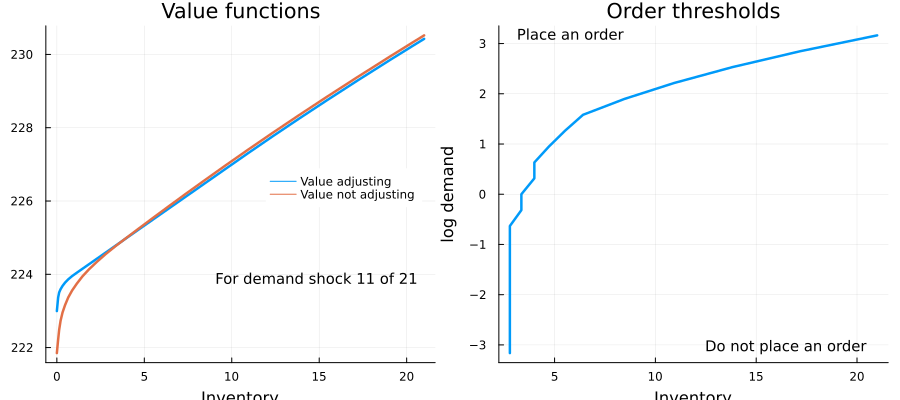

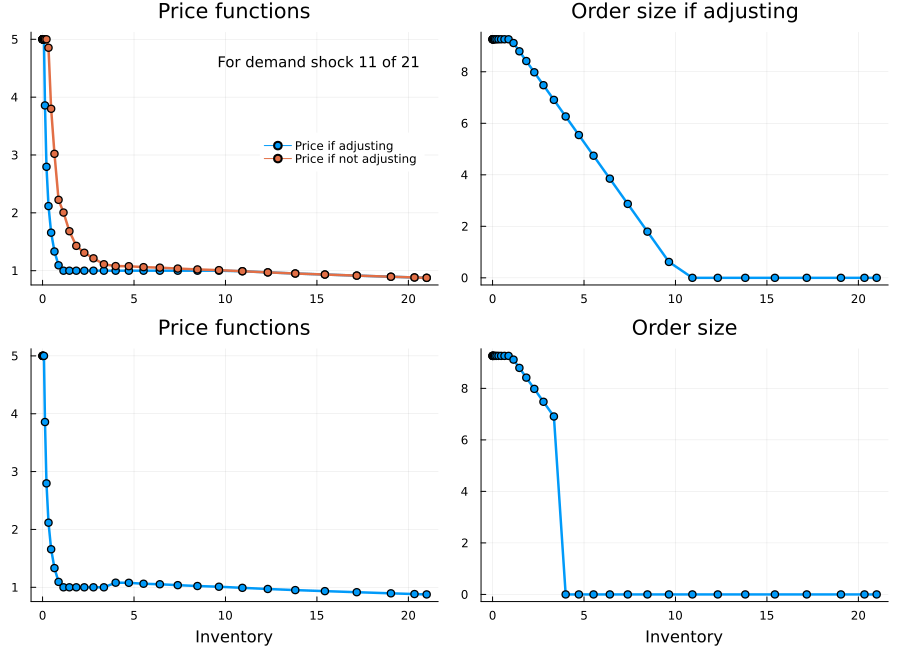

In [29]:
e, w, fspace, s, vnew, cnew, parameters, xa, xn = main();